# Big-Five Factor Markers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder,label_binarize,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_predict

#Modelling
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier

#Testing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score,roc_curve,auc,roc_auc_score

# Data Understanding

## Data Load

In [2]:
categorical_columns = [f"EXT{i}" for i in range(1, 11)] + \
                      [f"EST{i}" for i in range(1, 11)] + \
                      [f"AGR{i}" for i in range(1, 11)] + \
                      [f"CSN{i}" for i in range(1, 11)] + \
                      [f"OPN{i}" for i in range(1, 11)] + \
                      ['target']

float32_columns = [f"EXT{i}_E" for i in range(1, 11)] + \
                  [f"EST{i}_E" for i in range(1, 11)] + \
                  [f"AGR{i}_E" for i in range(1, 11)] + \
                  [f"CSN{i}_E" for i in range(1, 11)] + \
                  [f"OPN{i}_E" for i in range(1, 11)]

cat_types = {k: 'category' for k in categorical_columns}
float32_types = {k: 'float32' for k in float32_columns}
dtype = {**float32_types, **float32_types}
#dtype = {**cat_types, **float32_types}

df = pd.read_csv('dataset/BigFivePersonalityTest-TrainSet.csv', parse_dates = ['dateload'], dtype=dtype)
df.rename(columns={'Unnamed: 0':'id'},inplace = True)
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 999
df.head()

,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err,target
0,441310,3.00,3.00,3.00,3.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,3.00,4.00,3.00,4.00,4.00,4.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,5.00,0.00,4.00,4.00,4.00,3.00,3.00,3.00,3.00,4.00,3.00,4.00,3.00,4.00,3.00,2.00,3.00,4.00,3.00,4.00,1.00,4.00,3.00,4.00,3.00,"6,462.00","2,273.00","1,625.00","4,960.00","6,040.00","3,983.00","3,608.00","3,376.00","3,216.00","4,544.00","2,913.00","13,480.00","3,008.00","3,496.00","4,640.00","2,274.00","2,080.00","2,535.00","2,545.00","1,719.00","5,432.00","4,696.00","2,319.00","1,944.00","5,008.00","2,698.00",0.00,"23,048.00","2,040.00","3,608.00","2,528.00","4,008.00","2,361.00","2,528.00","2,760.00","7,662.00","4,736.00","2,697.00","2,095.00","1,704.00","2,958.00","2,471.00","2,184.00","1,880.00","3,024.00","2,375.00","2,456.00","1,840.00","2,016.00","2,232.00",2017-06-25 19:21:21,"1,920.00","1,080.00",7.00,186.00,21,1,US,35.057,-79.0147,C
1,985842,3.00,4.00,4.00,3.00,2.00,3.00,5.00,2.00,4.00,4.00,3.00,4.00,4.00,1.00,2.00,2.00,4.00,4.00,4.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,4.00,5.00,3.00,3.00,3.00,2.00,2.00,4.00,3.00,3.00,3.00,2.00,4.00,1.00,5.00,1.00,4.00,1.00,5.00,4.00,4.00,5.00,"35,691.00","2,218.00","1,492.00","1,685.00","2,667.00","1,757.00","3,513.00",906.00,"1,211.00","2,013.00","1,401.00","2,884.00","1,100.00","1,276.00","1,416.00","5,026.00","1,142.00","1,518.00","1,761.00","2,382.00","1,426.00",995.00,"1,873.00","1,705.00","1,259.00","1,215.00","1,607.00","2,478.00","1,115.00","1,064.00","1,618.00","2,390.00","1,139.00","1,925.00","1,356.00","3,875.00","1,291.00","2,916.00","1,315.00","2,181.00","1,122.00",834.00,"2,201.00","10,365.00","1,283.00","1,490.00","2,185.00","1,318.00","1,227.00","1,247.00",2018-10-24 08:10:07,"1,366.00",768.00,15.00,133.00,7,14,SG,1.2931,103.8558,N
2,628988,3.00,3.00,2.00,3.00,2.00,3.00,1.00,2.00,2.00,5.00,2.00,4.00,2.00,1.00,4.00,3.00,2.00,3.00,4.00,4.00,3.00,4.00,1.00,2.00,4.00,4.00,2.00,2.00,4.00,3.00,2.00,2.00,2.00,4.00,1.00,4.00,4.00,4.00,0.00,2.00,2.00,2.00,5.00,1.00,3.00,2.00,3.00,3.00,4.00,4.00,"30,932.00","2,514.00","4,927.00","8,252.00","7,885.00","3,500.00","3,973.00","1,231.00","1,117.00","1,309.00",985.00,926.00,"1,133.00","5,290.00","33,489.00","3,101.00","2,600.00","12,058.00","6,068.00",684.00,"13,743.00","1,823.00","2,268.00","2,891.00","4,402.00","4,891.00","6,840.00","2,899.00","11,554.00","2,416.00","2,498.00","3,435.00","11,042.00","12,779.00","1,510.00","4,093.00","4,769.00","12,279.00",0.00,"9,355.00","4,027.00","4,616.00","1,974.00","2,000.00","3,203.00","4,126.00","2,514.00","4,169.00","1,800.00","5,787.00",2018-02-26 18:56:06,"1,680.00","1,050.00",3.00,286.00,16,11,HK,22.25,114.1667,N
3,704960,3.00,3.00,2.00,3.00,3.00,4.00,1.00,3.00,4.00,5.00,4.00,2.00,5.00,3.00,2.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,4.00,4.00,2.00,5.00,2.00,3.00,4.00,5.00,3.00,5.00,5.00,3.00,2.00,4.00,1.00,2.00,5.00,3.00,3.00,4.00,3.00,3.00,3.00,2.00,3.00,3.00,5.00,3.00,"8,624.00","2,872.00","5,600.00","3,152.00","5,775.00","1,753.00","4,208.00","5,648.00","7,136.00","1,704.00","2,361.00","7,576.00","2,360.00","5,584.00","3,328.00","2,728.00","2,567.00","2,880.00","1,120.00","4,376.00","3,113.00","1,681.00","2,400.00","3,415.00","3,921.00","3,120.00","4,672.00","4,344.00","4,064.00","3,457.00","3,071.00","2,920.00","2,792.00","1,9

## Data Description

### Volume of the data

In [3]:
print(f'Train dataset has {df.shape[0]} records and {df.shape[1]} features.')

Train dataset has 964573 records and 112 features.


### Data Types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964573 entries, 0 to 964572
Columns: 112 entries, id to target
dtypes: datetime64[ns](1), float32(50), float64(54), int64(3), object(4)
memory usage: 640.2+ MB


### Variables in the Dataset

In [5]:
df.columns.values

array(['id', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'EXT8', 'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5',
       'EST6', 'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2', 'AGR3',
       'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1',
       'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9',
       'CSN10', 'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7',
       'OPN8', 'OPN9', 'OPN10', 'EXT1_E', 'EXT2_E', 'EXT3_E', 'EXT4_E',
       'EXT5_E', 'EXT6_E', 'EXT7_E', 'EXT8_E', 'EXT9_E', 'EXT10_E',
       'EST1_E', 'EST2_E', 'EST3_E', 'EST4_E', 'EST5_E', 'EST6_E',
       'EST7_E', 'EST8_E', 'EST9_E', 'EST10_E', 'AGR1_E', 'AGR2_E',
       'AGR3_E', 'AGR4_E', 'AGR5_E', 'AGR6_E', 'AGR7_E', 'AGR8_E',
       'AGR9_E', 'AGR10_E', 'CSN1_E', 'CSN2_E', 'CSN3_E', 'CSN4_E',
       'CSN5_E', 'CSN6_E', 'CSN7_E', 'CSN8_E', 'CSN9_E', 'CSN10_E',
       'OPN1_E', 'OPN2_E', 'OPN3_E', 'OPN4_E', 'OPN5_E', 'OPN6_E',
       'OPN7_E', 'OPN8_E', 

Further information about the columns can be found below.  

**Question Columns**  
Find below further information about the question columns  

|Column| Question|
|:-:|:---|
|EXT1|I am the life of the party
|EXT2|I don't talk a lot
|EXT3|I feel comfortable around people
|EXT4|I keep in the background
|EXT5|I start conversations
|EXT6|I have little to say
|EXT7|I talk to a lot of different people at parties
|EXT8|I don't like to draw attention to myself
|EXT9|I don't mind being the center of attention
|EXT10|I am quiet around strangers
|EST1|I get stressed out easily
|EST2|I am relaxed most of the time
|EST3|I worry about things
|EST4|I seldom feel blue
|EST5|I am easily disturbed
|EST6|I get upset easily
|EST7|I change my mood a lot
|EST8|I have frequent mood swings
|EST9|I get irritated easily
|EST10|I often feel blue
|AGR1|I feel little concern for others
|AGR2|I am interested in people
|AGR3|I insult people
|AGR4|I sympathize with others' feelings
|AGR5|I am not interested in other people's problems
|AGR6|I have a soft heart
|AGR7|I am not really interested in others
|AGR8|I take time out for others
|AGR9|I feel others' emotions
|AGR10|I make people feel at ease
|CSN1|I am always prepared
|CSN2|I leave my belongings around
|CSN3|I pay attention to details
|CSN4|I make a mess of things
|CSN5|I get chores done right away
|CSN6|I often forget to put things back in their proper place
|CSN7|I like order
|CSN8|I shirk my duties
|CSN9|I follow a schedule
|CSN10|I am exacting in my work
|OPN1|I have a rich vocabulary
|OPN2|I have difficulty understanding abstract ideas
|OPN3|I have a vivid imagination
|OPN4|I am not interested in abstract ideas
|OPN5|I have excellent ideas
|OPN6|I do not have a good imagination
|OPN7|I am quick to understand things
|OPN8|I use difficult words
|OPN9|I spend time reflecting on things
|OPN10|I am full of ideas

The scale was labeled 1=Disagree, 3=Neutral, 5=Agree  
The time spent on each question is also recorded in milliseconds These are the variables ending in **\_E**  

**Other Columns**  

|Column|Description|
|:-:|:---|
|dateload|The timestamp when the survey was started
|screenw|The width the of user's screen in pixels
|screenh|The height of the user's screen in pixels
|introelapse|The time in seconds spent on the landing page
|testelapse|The time in seconds spent on the page with the survey questions
|endelapse|The time in seconds spent on the finalization page 
|IPC|The number of records from the user's IP address in the dataset
|country|The country*
|lat_appx_lots_of_err|Approximate latitude of user*
|long_appx_lots_of_err|Approximate longitude of user*
|target|The trait with max value of the test

*Determined by technical information

### Descriptive Analysis

In [6]:
df.describe()

,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"964,573.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,611.00","962,611.00","962,611.00","962,863.00","964,573.00","964,573.00"
mean,"507,687.98",2.65,2.77,3.29,3.14,3.28,2.40,2.77,3.41,2.96,3.56,3.29,3.16,3.85,2.66,2.84,2.84,3.05,2.68,3.09,2.77,2.26,3.83,2.26,3.93,2.27,3.74,2.20,3.69,3.79,3.59,3.30,2.93,3.98,2.62,2.63,2.83,3.70,2.47,3.20,3.59,3.65,2.08,4.00,2.00,3.79,1.89,3.98,3.18,4.12,3.96,"98,303.90","7,868.34","11,745.72","7,488.71","7,204.35","7,520.51","11,095.22","7,097.06","6,189.11","7,556.75","9,611.44","9,304.36","7,805.62","10,855.95","10,405.29","8,276.98","6,979.06","8,080.31","5,464.28","4,760.57","18,399.51","8,656.28","6,649.63","9,090.83","11,311.81","6,211.18","8,382.48","9,099.23","5,352.74","6,098.79","12,310.78","10,173.75","8,854.17","9,184.09","9,131.42","11,617.35","5,615.05","10,904.71","5,500.40","11,005.06","8,574.33","13,270.75","7,135.83","13,599.01","6,264.19","8,307.59","7,780.77","5,470.92","6,385.60","5,428.93","1,149.46",826.32,957.42,660.47,"2,777.03",10.45
std,"293,090.74",1.26,1.32,1.22,1.24,1.28,1.23,1.40,1.27,1.35,1.31,1.35,1.23,1.16,1.25,1.27,1.33,1.29,1.34,1.30,1.32,1.34,1.14,1.28,1.13,1.17,1.22,1.12,1.10,1.17,1.08,1.18,1.39,1.04,1.25,1.27,1.42,1.13,1.14,1.28,1.05,1.16,1.11,1.10,1.09,0.99,1.10,1.01,1.26,1.04,1.03,"4,992,401.50","441,714.69","2,386,077.75","326,273.72","616,677.00","580,364.75","2,246,859.25","377,292.97","254,007.56","2,200,702.25","1,273,595.25","638,532.81","726,467.69","1,131,015.38","2,235,275.75","719,566.44","398,919.06","2,210,038.50","449,060.94","174,032.91","1,772,232.62","722,187.31","263,899.03","773,435.00","2,235,321.00","343,937.00","684,252.94","1,436,147.25","163,695.05","312,378.41","1,335,930.00","576,368.50","1,246,966.62","731,616.06","1,040,988.88","2,291,148.50","275,729.19","513,744.66","414,599.50","2,262,755.75","955,851.50","1,253,111.75","372,066.84","3,126,721.50","343,716.78","574,789.44","598,264.56","269,737.75","440,852.66","452,223.84",560.05,180.26,"51,912.03","15,824.76","1,522,388.82",39.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

Negative Values and Outliers can be found in time columns, this values will be transformed in **Data Transformation** section.  
Target variable `target` will be analyzed in **Exploratory Data Analysis** section.

### Missing Values

In [7]:
df.replace(to_replace = 0, value = np.nan,inplace = True)
df.isnull().sum()[df.isnull().sum()>0].to_frame('Nulls %').sort_values(by = 'Nulls %')/len(df)*100

,Nulls %
id,0.00
country,0.01
testelapse,0.18
target,0.18
introelapse,0.21
...,...
AGR6_E,1.62
EST2_E,1.63
EST6_E,1.67
EST4_E,1.68


The NaN values represent the 2% of the dataset in the worst case, then this values will be dropped.

In [8]:
df.dropna(axis = 0,inplace = True)

## Exploratory Data Analysis

### Target Variable
This variable corresponds to the trait with max value of the test. Further information about the traits can be found below.  

|Trait|Class|Description|
|:--:|:--:|:---|
|Extroversion|E|**High scores:** People who tend to be social<br>**Low scores:** People who prefer to work alone in projects|
|Agreeableness|A|**High scores:** Politically correct people<br>**Low Scores:** Direct people|
|Conscientiousness|C|**High Scores:** People who tend to follow the rules and prefer order<br>**Low Scores:** People who tend to be disorganized|
|Neuroticism|N|How emotional the person can be|
Openness to Experience|O|**High Scores:** People who tend to “dream with their eyes open”<br>**Low Scores:** People who tend to “have their feet on the ground”|

In [9]:
target_classes = list(df['target'].unique())
print(f'Unique classes in target variable: {target_classes}')

Unique classes in target variable: ['N', 'C', 'E', 'O', 'A']


#### Distribution
Plese find below an distribution analysis of the target variable.

##### Balance of Classes

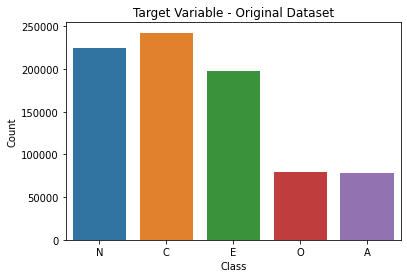

In [10]:
sns.countplot(df['target'],order = target_classes)
plt.title('Target Variable - Original Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

##### Distribution in Test Answers

###### Globally

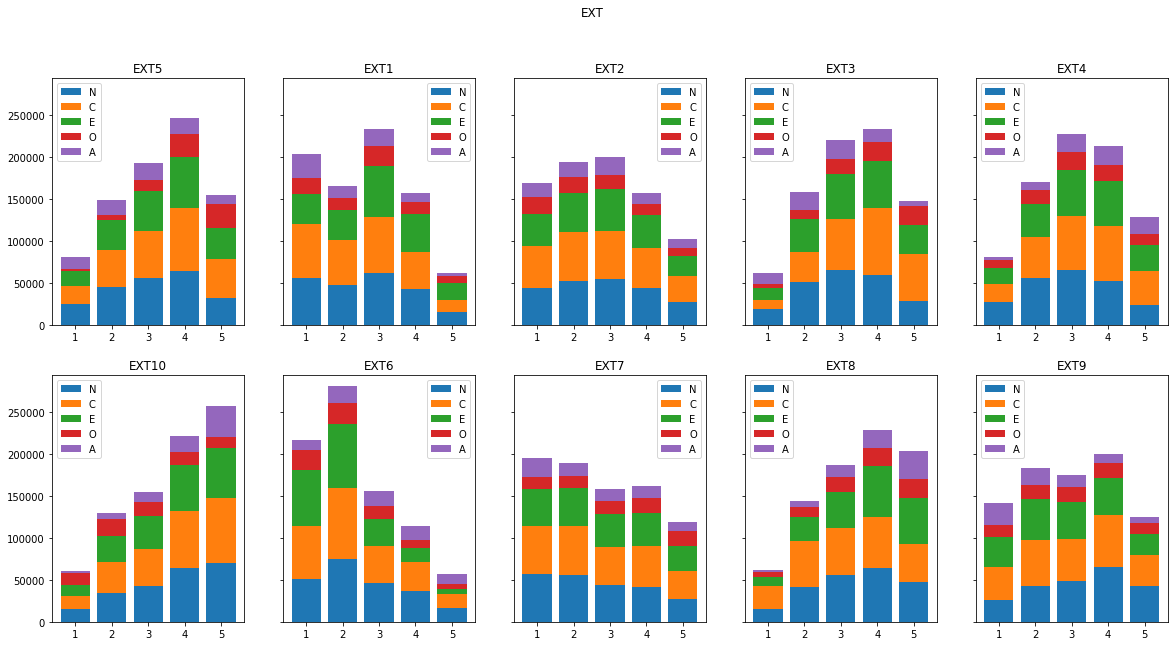

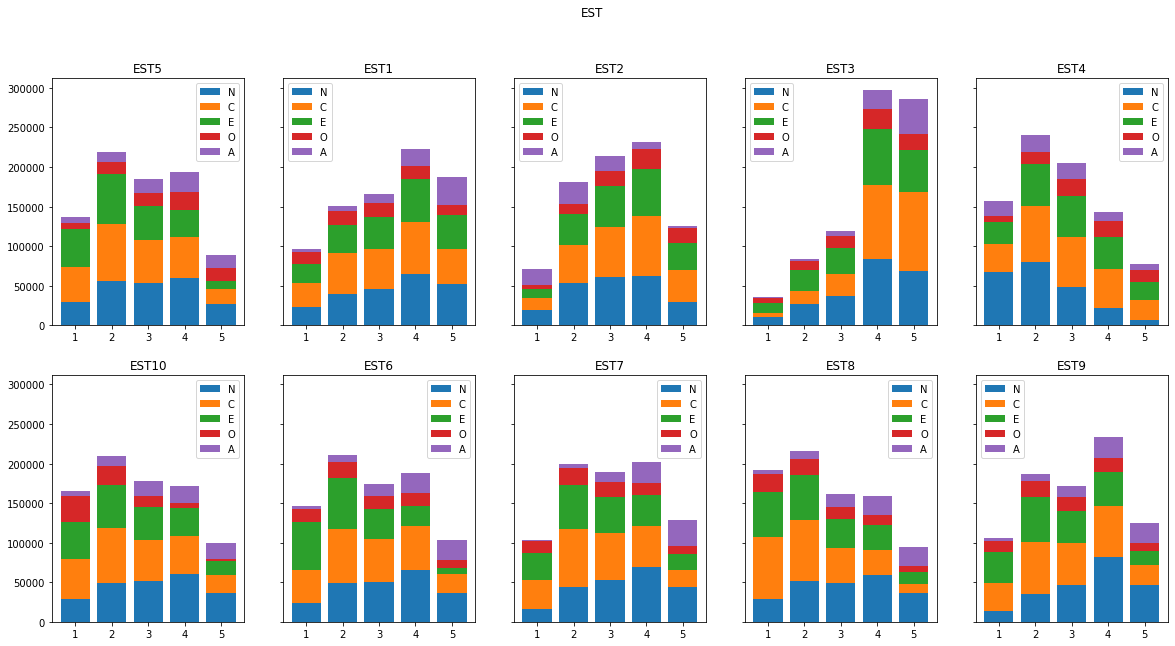

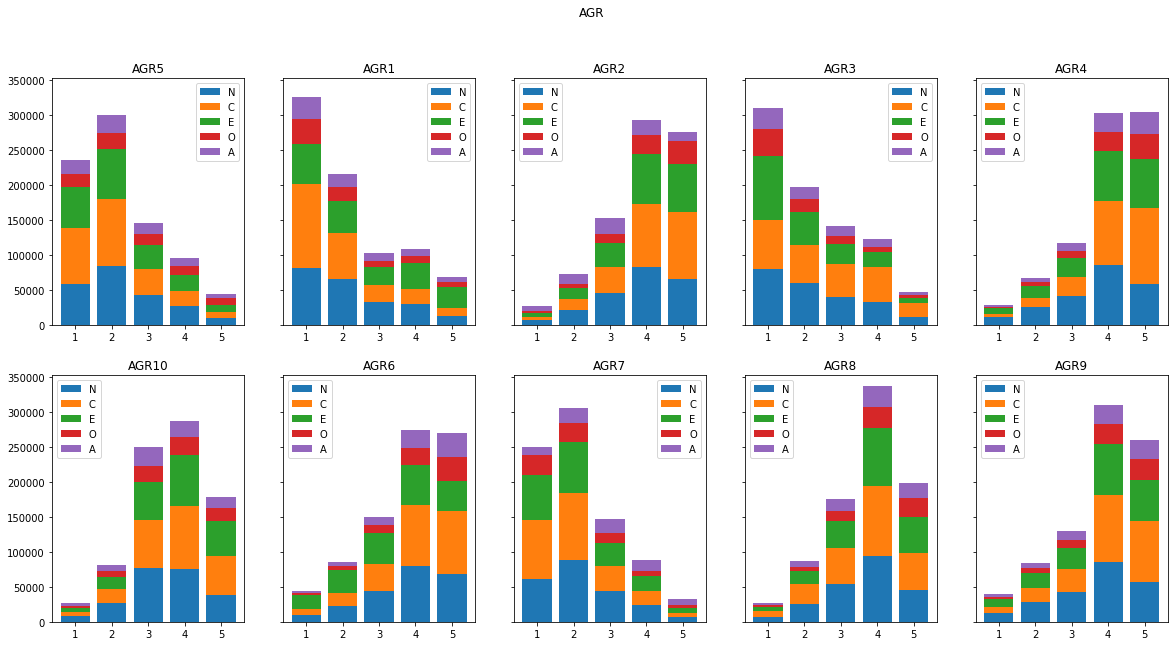

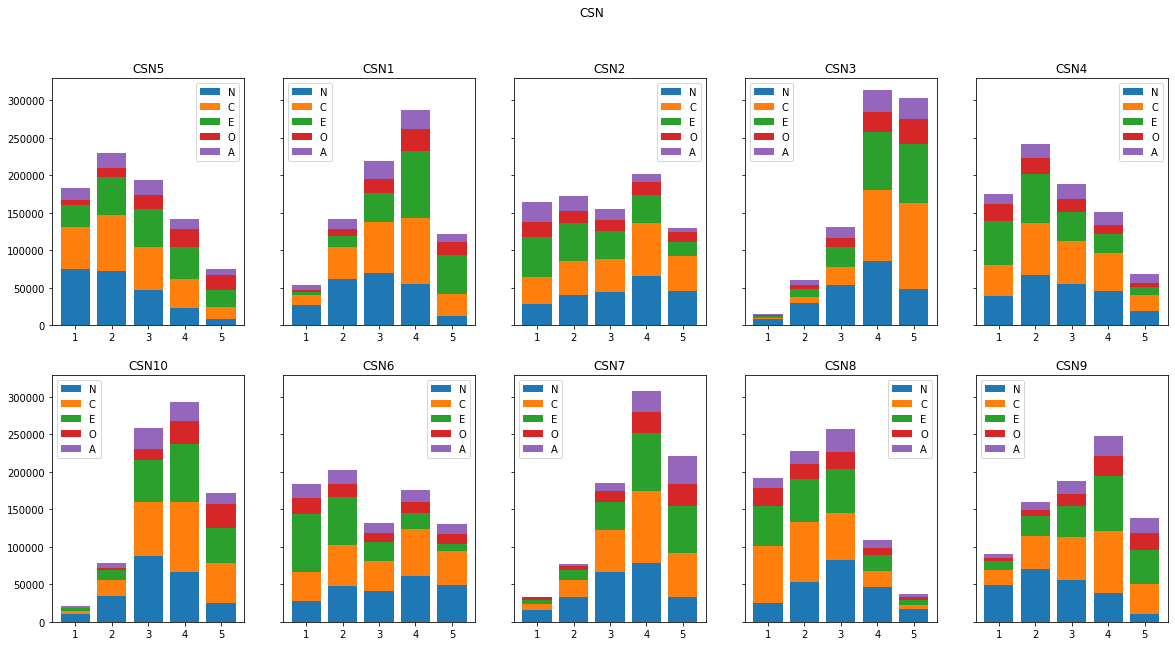

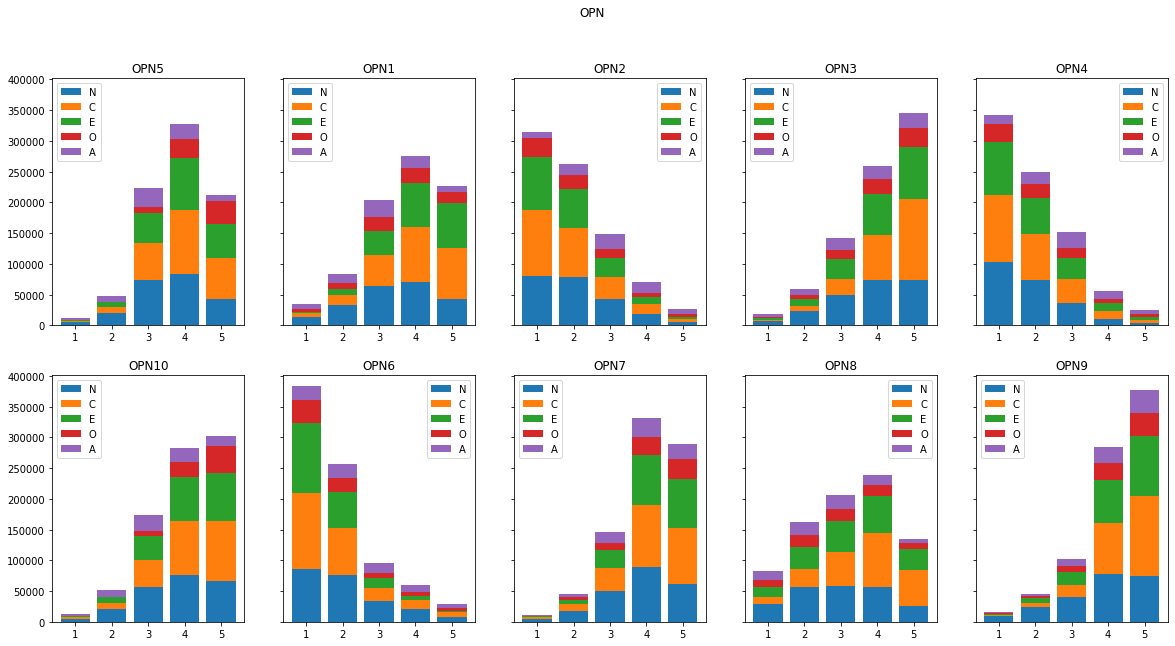

In [11]:
q_types = ['EXT', 'EST', 'AGR', 'CSN', 'OPN']
targets = df['target'].unique()

for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for i, question in enumerate(questions):
        ax = axis[round((i+1)/10), (i + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        cumsum = np.cumsum(targets_data, axis=0)
        for i in range(len(targets_data)):
            if i == 0:
                ax.bar(targets_data[i].index, targets_data[i], label=targets[i])
            else:
                ax.bar(targets_data[i].index, targets_data[i], bottom=cumsum[i - 1], label=targets[i])

            ax.legend()

###### Per target

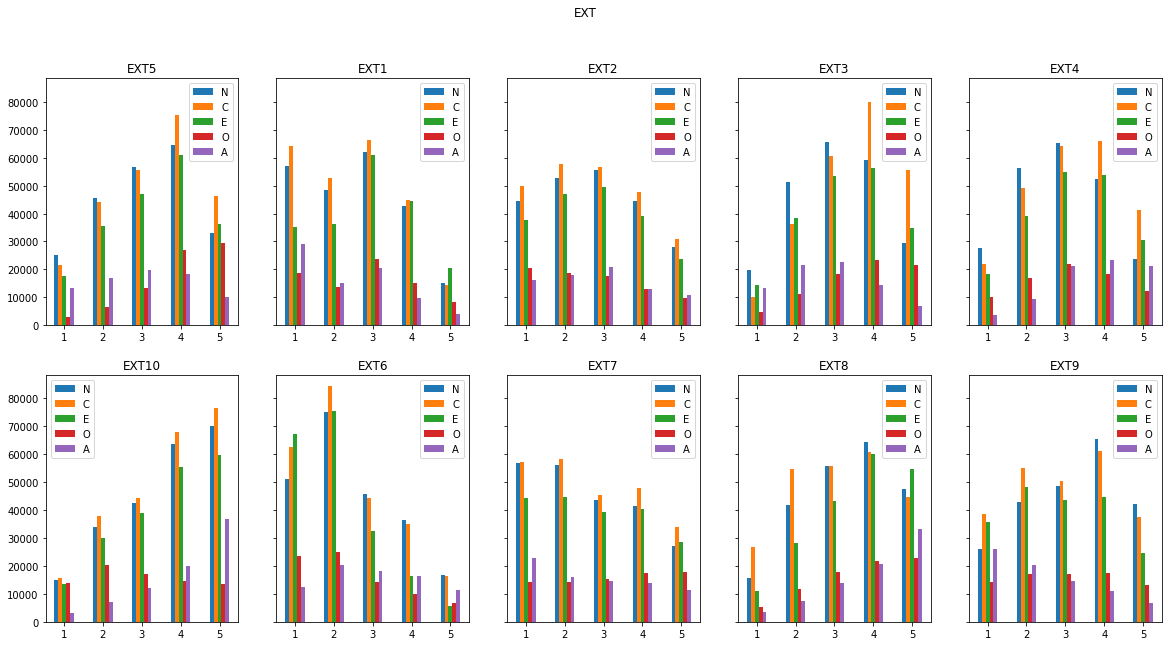

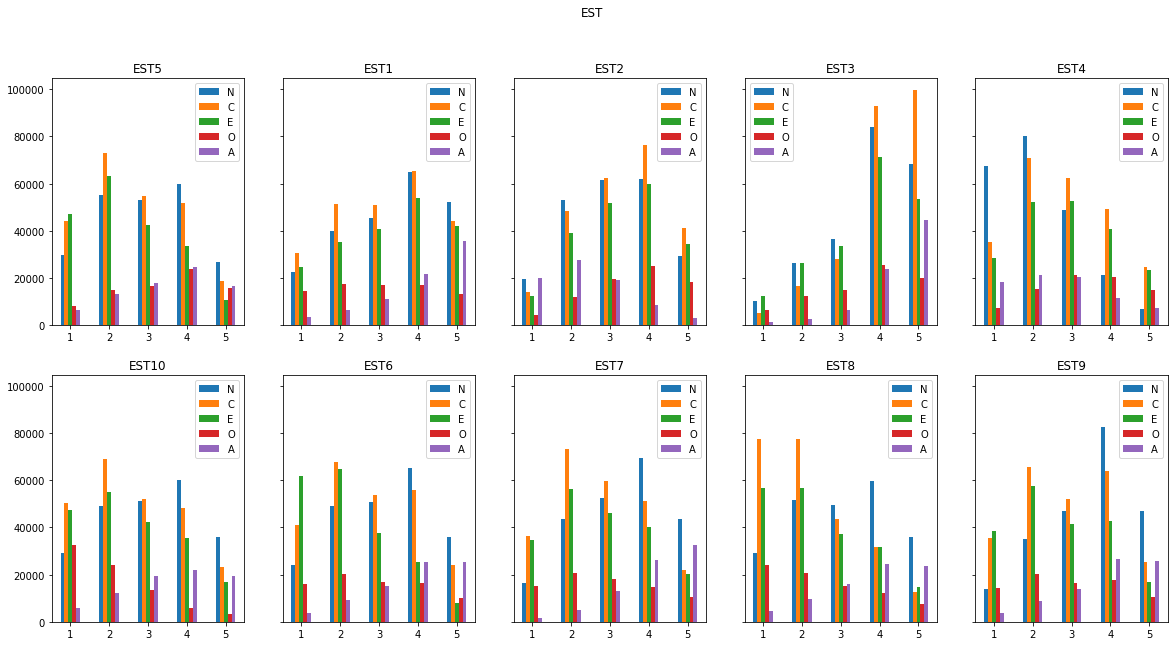

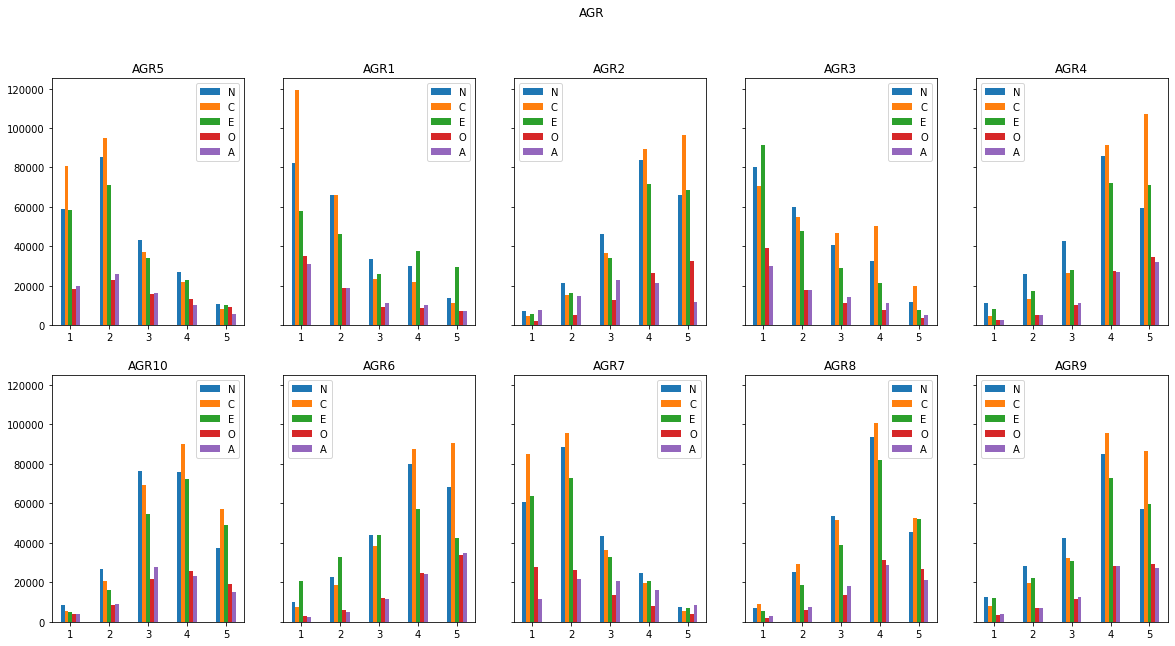

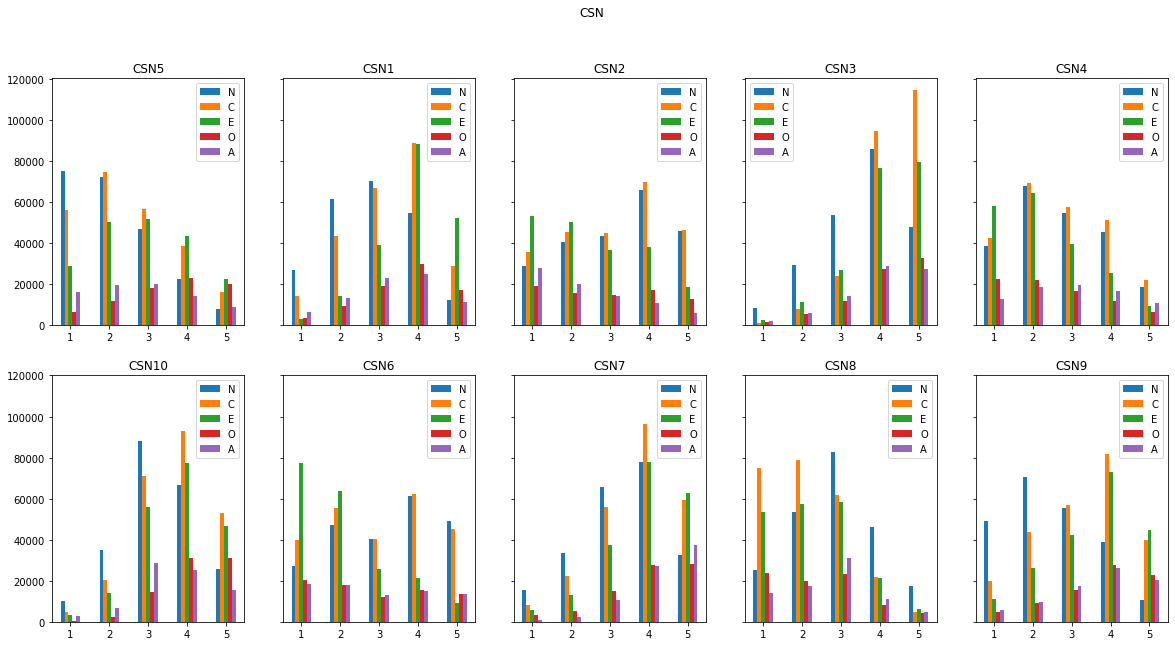

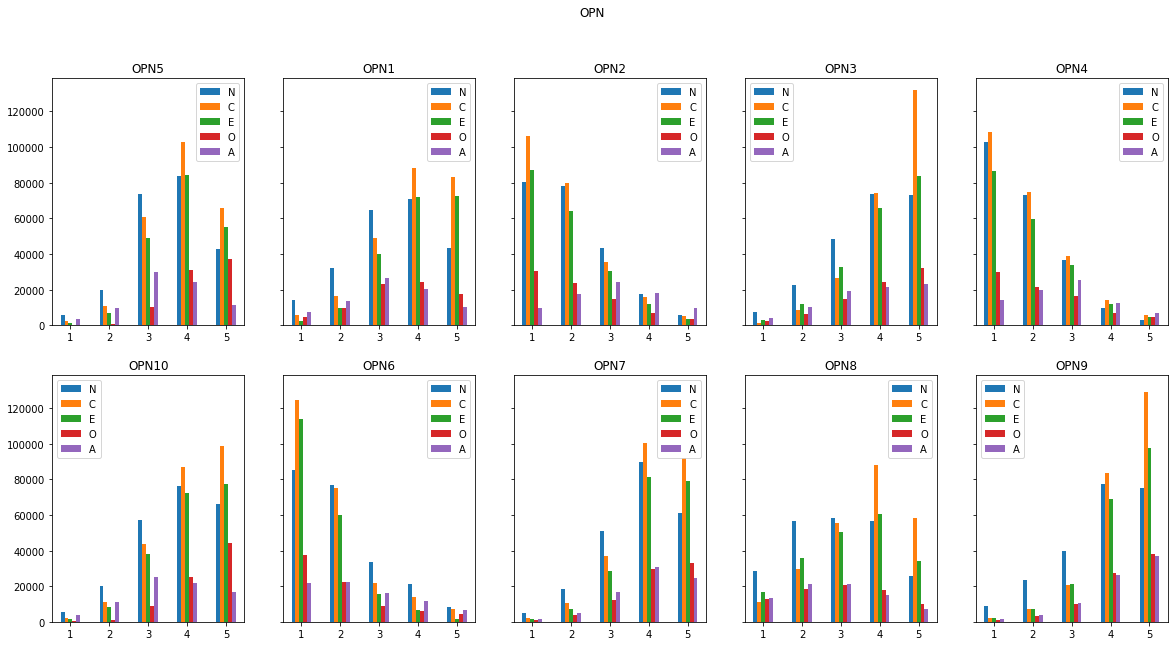

In [12]:
width = 0.1
for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for j, question in enumerate(questions):
        ax = axis[round((j+1)/10), (j + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        for i in range(len(targets_data)):
            ax.bar(targets_data[i].index + (i - 2) * width, targets_data[i], width, label=targets[i])
            ax.set_xticks(targets_data[i].index)
            ax.legend()

## Data Preparation

Columns containing IDs, dates, computer specifications and geographic information do not add valuable information to solve the problem at hand. These will be deleted from the dataset.

In [13]:
labels = ['id','dateload','screenw','screenh','IPC','testelapse','endelapse',
          'introelapse','country','lat_appx_lots_of_err','long_appx_lots_of_err']
df.drop(labels = labels, inplace = True, axis = 1)

According to the descriptive analysis of the dataset the columns referencing the time spent answering questions contain incoherent information (negative values) and significant outliers. In addition, the scale of these records will be narrowed from miliseconds to minutes, as follows:

- Take the absolute value of record
- Conversion of the record from milliseconds to minutes  
- Imputation of outliers to median value*

*The outliers had been imputed to median due to the fact that this statistic is not affected by outliers.

In [14]:
df_columns = df.columns
time_columns = []

for col in df_columns:
    if '_E' in str(col):
        time_columns.append(col)
        df[col] = df[col].apply(lambda x: abs(x/1000/60))
        q1 = df[col].quantile(0.25)
        q2 = df[col].quantile(0.50)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        df[col] = df[col].apply(lambda x: q2 if (x>=q3 + 1.5*iqr) else x)

### Categorical Values
The distinct classes in the target variable had been encoded from character to integer numbers.

In [15]:
le = LabelEncoder()
le.fit(target_classes)
df['target'] = le.transform(df['target'])
print(f'Before encoding:{le.classes_}')
print(f'After encoding: {le.transform(le.classes_)}')

Before encoding:['A' 'C' 'E' 'N' 'O']
After encoding: [0 1 2 3 4]


The encoder mapped the distinct classes in target variable as follows:

\begin{align}
\begin{bmatrix}
       A \\
       C \\
       E \\
       N \\
       O \\
     \end{bmatrix} &= \begin{bmatrix}
       0 \\
       1 \\
       2 \\
       3 \\
       4 \\
     \end{bmatrix}
\end{align}

## Feature Selection

### Chi-Squared
Selecting the Best k Features

In [16]:
bestfeatures = SelectKBest(score_func=chi2, k=52)
fit = bestfeatures.fit(df.drop('target',axis=1),df['target'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop('target',axis=1).columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
featureScores.sort_values(by='Score',ascending=False).head(52)

,Feature,Score
17,EST8,"62,879.74"
35,CSN6,"56,973.04"
15,EST6,"55,046.76"
38,CSN9,"51,710.09"
34,CSN5,"46,084.98"
16,EST7,"44,817.23"
19,EST10,"41,723.66"
41,OPN2,"39,691.27"
18,EST9,"37,909.36"
30,CSN1,"35,380.73"


The time columns will be dropped, as well as, the last two columns which lowest score following Chi-Squared results. Keeping 50 features in total.

In [17]:
df.drop(labels = time_columns, axis=1,inplace = True)
col = df.drop('target',axis=1).columns.values
print(f'Models will be trained with the following features\n{col}')

Models will be trained with the following features
['EXT1' 'EXT2' 'EXT3' 'EXT4' 'EXT5' 'EXT6' 'EXT7' 'EXT8' 'EXT9' 'EXT10'
 'EST1' 'EST2' 'EST3' 'EST4' 'EST5' 'EST6' 'EST7' 'EST8' 'EST9' 'EST10'
 'AGR1' 'AGR2' 'AGR3' 'AGR4' 'AGR5' 'AGR6' 'AGR7' 'AGR8' 'AGR9' 'AGR10'
 'CSN1' 'CSN2' 'CSN3' 'CSN4' 'CSN5' 'CSN6' 'CSN7' 'CSN8' 'CSN9' 'CSN10'
 'OPN1' 'OPN2' 'OPN3' 'OPN4' 'OPN5' 'OPN6' 'OPN7' 'OPN8' 'OPN9' 'OPN10']


### Correlation Matrix
The following matrix gives an insight of the strengt of linear association between independent variables.

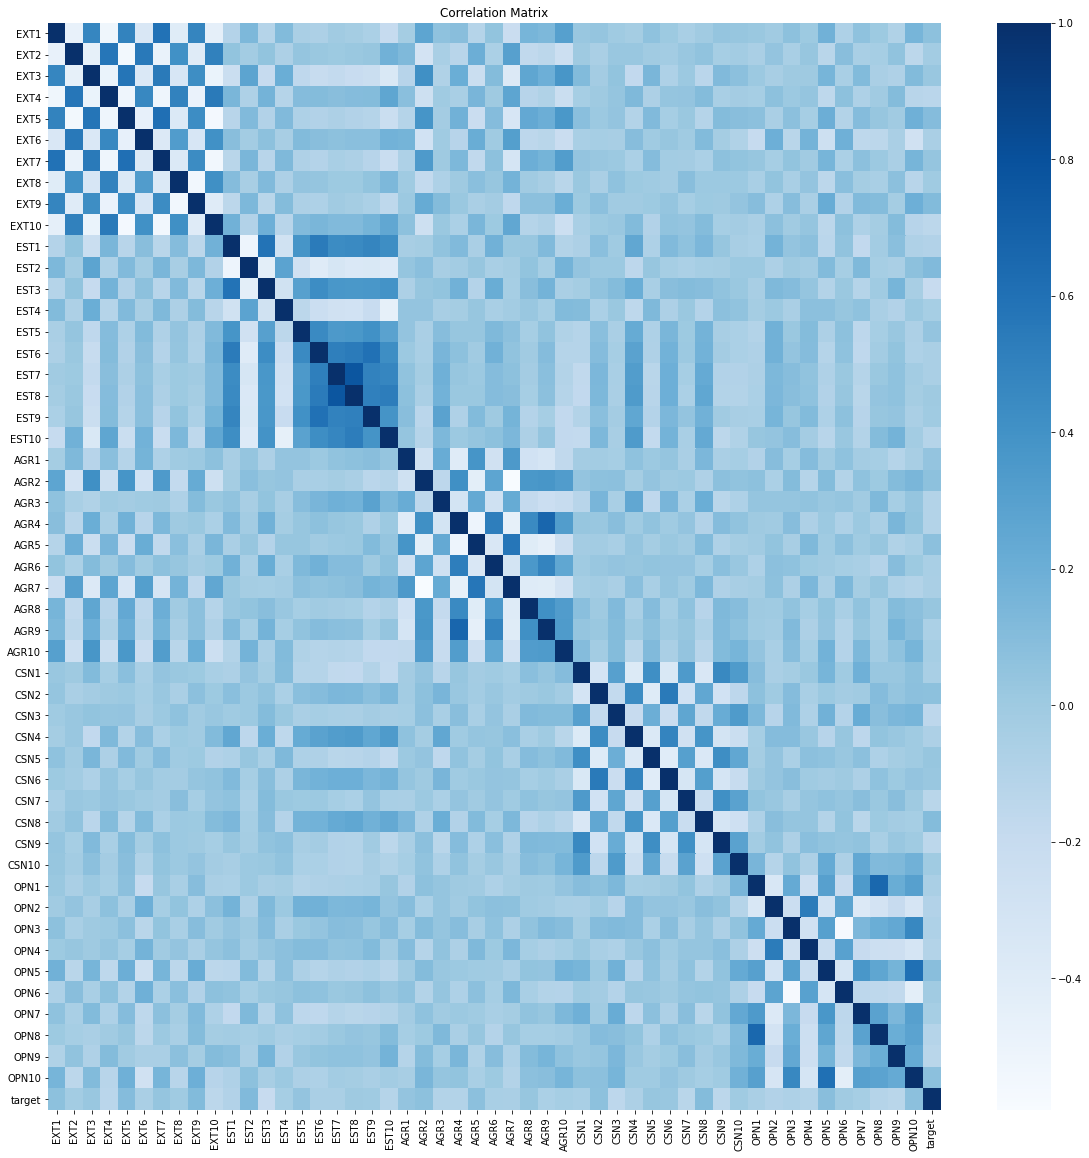

In [18]:
corr = df.drop('target',axis=1).corr(method='pearson')
fig,ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(corr,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

Some clusters along common topic of anwers can be found in the correlation matrix, but there is no significant correlation between variables which can lead to an issue of multicolinearity.

# Modelling
The problem at hand requires an algorithm that maps the input data to the specific category, as well as, it will predict the class for the new data. Different classifiers can be found, 

- **Binary Classification:** Classification task with two possible outcomes, e.g., Gender classification (Male/Female)
- **Multi-class classification:** Classification with more than two classes. In multi-class classification, each sample is assigned to one and only one target label, e.g., an animal can be a cat or dog but not both at the same time.
- **Multi-label classification:** Classification task where each sample is mapped to a set of target labels (more than one class), e.g., a news article can be about sports, a person, and location at the same time.

The problem at hand might be tackled with a Multi-Class Classifier.

Due to the fact that the distinct classes in target variable are imbalanced, two approaches to solve this problem will be followed:
- Undersampling the data
- Oversampling the data

## Undersampled Dataset
Start by randomly dropping records in the dataset in order to balance the proportion if distinct classes in target variable. Then the undersampled dataset will be split into training and testing set.

In [19]:
sm = RandomUnderSampler(random_state=0,sampling_strategy='all')
X_res, y_res = sm.fit_resample(df.drop('target',axis=1), df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, 
                                                    random_state=0, shuffle=True, stratify = y_res)

The balance of the distinct classes in the target variable will be checked as follows.

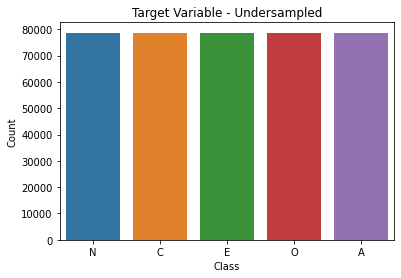

In [20]:
sns.countplot(le.inverse_transform(y_res),order = target_classes)
plt.title('Target Variable - Undersampled')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Create a dictionary to store the trained models.

In [21]:
models = {}

### Logistic Regression

In [22]:
logistic = LogisticRegression(n_jobs=-1, max_iter=300,random_state=0)
logistic.fit(X_train, y_train)
models[str(type(logistic).__name__)] = logistic

### SGD Classifier

In [23]:
sgd = SGDClassifier(random_state=0,alpha=1e-5,epsilon=1e-2,average=True,loss='log',early_stopping=True)
sgd.fit(X_train,y_train)
models[str(type(sgd).__name__)] = sgd

### Random Forest

In [24]:
randomf = RandomForestClassifier(criterion='gini',n_estimators=50,random_state=0,max_depth=50)
randomf.fit(X_train,y_train)
models[str(type(randomf).__name__)] = randomf

### Bayes Classifier

In [25]:
bayes = CategoricalNB()
bayes.fit(X_train, y_train)
models[str(type(bayes).__name__)] = bayes

## Error Analysis

Function which plots the confusion matrix for multiple models.

In [26]:
def plot_conf_mat(models,X,y,label):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.suptitle(f'Confusion Matrix - {label}',fontsize=16)

    for model, ax in zip(models, axes.flatten()):
        estimator = models[str(model)]

        plot_confusion_matrix(estimator, 
                              X, 
                              y, 
                              ax=ax, 
                              cmap='Blues',
                              normalize= 'all',
                              values_format = '.2f',
                              display_labels=list(le.classes_))
        ax.title.set_text(type(estimator).__name__)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
    plt.show()

Function which prints the classification report for each model.

In [27]:
def classif_report(models,X_test,y_test):
    for model in models:

        estimator = models[str(model)]
        y_pred = models[str(model)].predict(X_test)
        report = classification_report(y_test,y_pred,
                                       output_dict=True,
                                       target_names=list(le.classes_))
        clsf_report = pd.DataFrame(report).transpose()
        print(model)
        print(clsf_report)
        print()

Function which print the accuracy of the models.

In [28]:
def accuracy_score_models(models,X_test):
    for model in models:
        estimator = models[str(model)]
        y_pred = estimator.predict(X_test)
        print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),2))

Function which plots ROC Curve for the multiclass case.

In [29]:
def plot_roc_curve_multiclass(estimator,X,y,label = None):
    # Binarize the output
    y = label_binarize(y, classes=[0,1,2,3,4])
    n_classes = y.shape[1]

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=0,shuffle=True,stratify = y)

    # Learn to predict each class against the other
    y_score = estimator.decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    lw = 2

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8,8))

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','darkviolet','gold'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'''.format(le.inverse_transform([i])[0],roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw,label='No Skill (area = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title(f'ROC Curve - {type(estimator).__name__} {label}',fontsize=11)
    plt.legend(loc="lower right",frameon=False,fontsize=11)
    plt.show()

### Confusion Matrix

#### Training Set

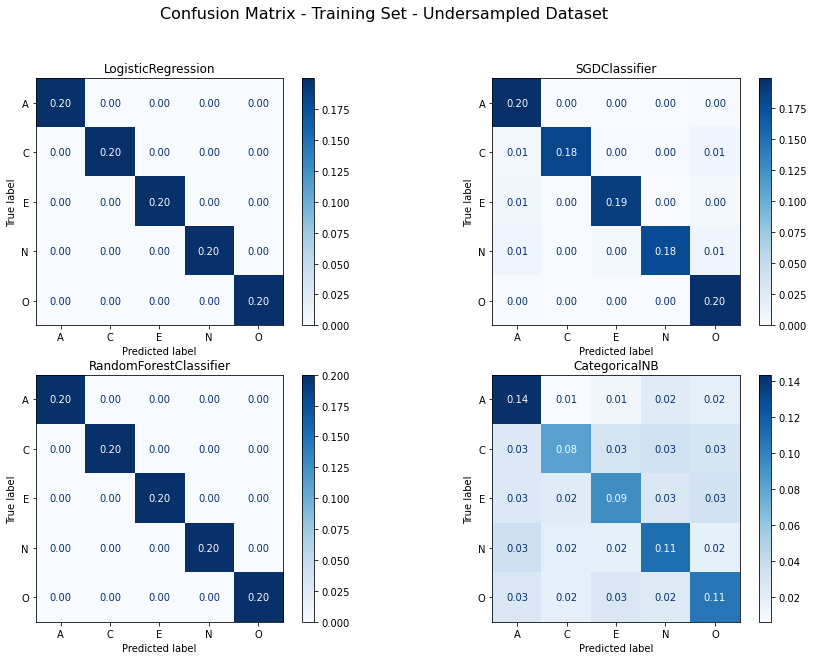

In [30]:
plot_conf_mat(models,X_train,y_train,label='Training Set - Undersampled Dataset')

### Test Set

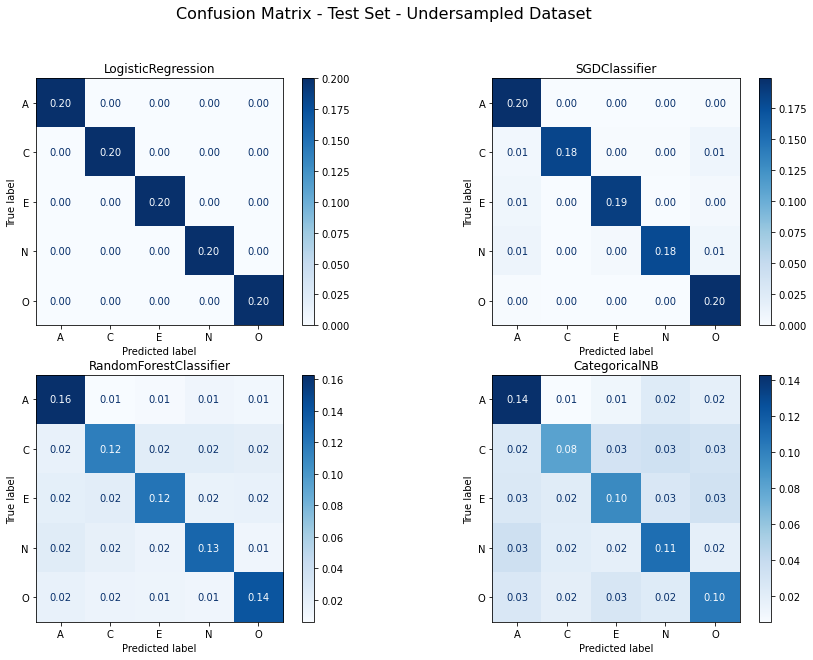

In [31]:
plot_conf_mat(models,X_test,y_test,label='Test Set - Undersampled Dataset')

### Classification Report

In [32]:
classif_report(models,X_test,y_test)

LogisticRegression
              precision  recall  f1-score   support
A                  1.00    1.00      1.00 15,740.00
C                  1.00    1.00      1.00 15,741.00
E                  1.00    1.00      1.00 15,740.00
N                  1.00    1.00      1.00 15,741.00
O                  1.00    1.00      1.00 15,741.00
accuracy           1.00    1.00      1.00      1.00
macro avg          1.00    1.00      1.00 78,703.00
weighted avg       1.00    1.00      1.00 78,703.00

SGDClassifier
              precision  recall  f1-score   support
A                  0.89    1.00      0.94 15,740.00
C                  1.00    0.91      0.95 15,741.00
E                  0.97    0.94      0.96 15,740.00
N                  0.99    0.89      0.94 15,741.00
O                  0.90    0.99      0.95 15,741.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.95    0.95      0.95 78,703.00
weighted avg       0.95    0.95      0.95 78,703.00

RandomForestClassifier
      

### Accuracy Score

In [33]:
accuracy_score_models(models,X_test)

LogisticRegression 1.0
SGDClassifier 0.95
RandomForestClassifier 0.67
CategoricalNB 0.53


### Receiving Operating Characteristic Curve - Best Model

/Library/Python/3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


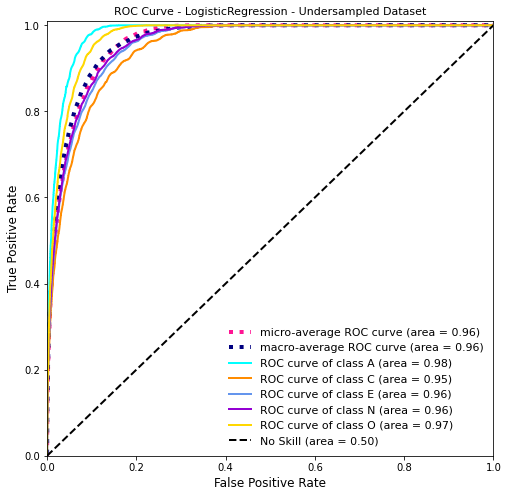

In [34]:
plot_roc_curve_multiclass(models['LogisticRegression'], X_res, y_res, label = '- Undersampled Dataset')

## Oversampled Dataset
Start by randomly Copying records in the dataset in order to balance the proportion if distinct classes in target variable. Then the undersampled dataset will be split into training and testing set.

In [35]:
sm = RandomOverSampler(random_state=0,sampling_strategy='all')
X_res, y_res = sm.fit_resample(df.drop('target',axis=1), df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, 
                                                    random_state=0,shuffle=True, stratify = y_res)

The balance of the distinct classes in the target variable will be checked as follows.

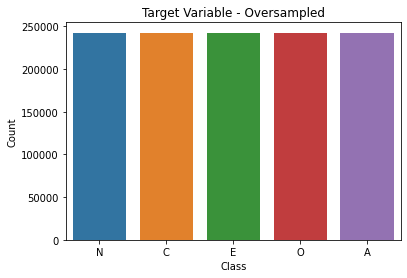

In [36]:
sns.countplot(le.inverse_transform(y_res),order=target_classes)
plt.title('Target Variable - Oversampled')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Create a dictionary to store the trained models.

In [37]:
models = {}

### Logistic Regression

In [38]:
logistic.fit(X_train, y_train)
models[str(type(logistic).__name__)] = logistic

### SGD Classifier

In [39]:
sgd.fit(X_train,y_train)
models[str(type(sgd).__name__)] = sgd

### Random Forest

In [40]:
randomf.fit(X_train,y_train)
models[str(type(randomf).__name__)] = randomf

### Bayes Classifier

In [41]:
bayes.fit(X_train, y_train)
models[str(type(bayes).__name__)] = bayes

## Error Analysis

### Confusion Matrix

#### Training Set

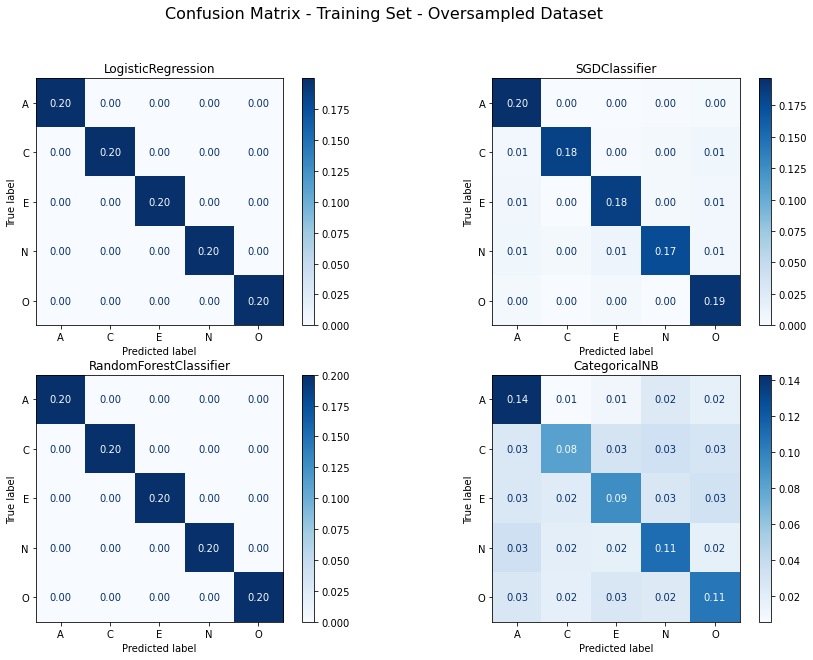

In [42]:
plot_conf_mat(models,X_train,y_train,label='Training Set - Oversampled Dataset')

#### Test Set

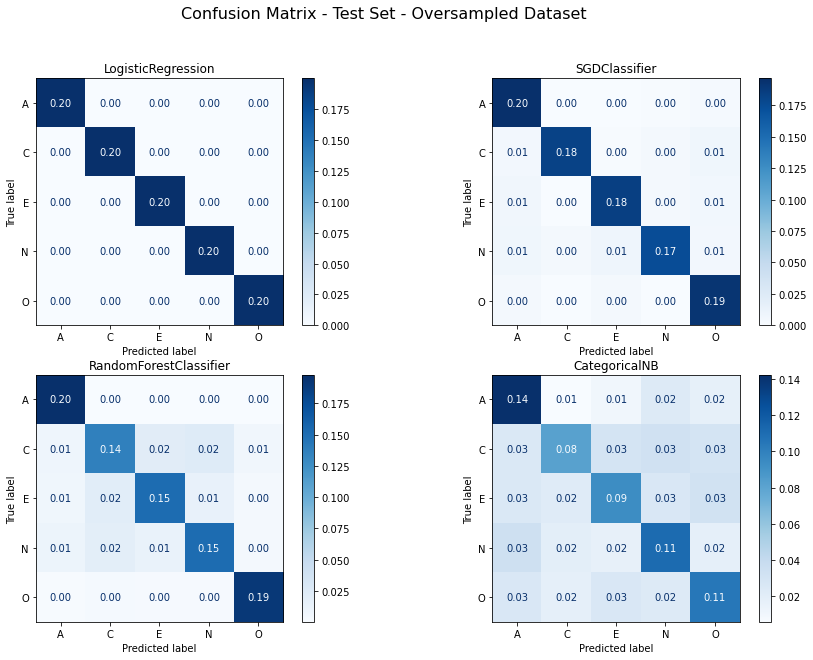

In [43]:
plot_conf_mat(models,X_test,y_test,label='Test Set - Oversampled Dataset')

### Classification Report

In [44]:
classif_report(models,X_test,y_test)

LogisticRegression
              precision  recall  f1-score    support
A                  1.00    1.00      1.00  48,502.00
C                  1.00    1.00      1.00  48,502.00
E                  1.00    1.00      1.00  48,502.00
N                  1.00    1.00      1.00  48,502.00
O                  1.00    1.00      1.00  48,502.00
accuracy           1.00    1.00      1.00       1.00
macro avg          1.00    1.00      1.00 242,510.00
weighted avg       1.00    1.00      1.00 242,510.00

SGDClassifier
              precision  recall  f1-score    support
A                  0.90    0.98      0.94  48,502.00
C                  0.98    0.91      0.94  48,502.00
E                  0.93    0.92      0.92  48,502.00
N                  0.95    0.87      0.91  48,502.00
O                  0.90    0.96      0.93  48,502.00
accuracy           0.93    0.93      0.93       0.93
macro avg          0.93    0.93      0.93 242,510.00
weighted avg       0.93    0.93      0.93 242,510.00

RandomFores

### Accuracy Score

In [45]:
accuracy_score_models(models,X_test)

LogisticRegression 1.0
SGDClassifier 0.93
RandomForestClassifier 0.83
CategoricalNB 0.53


### ROC Curve  - Best Model

/Library/Python/3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


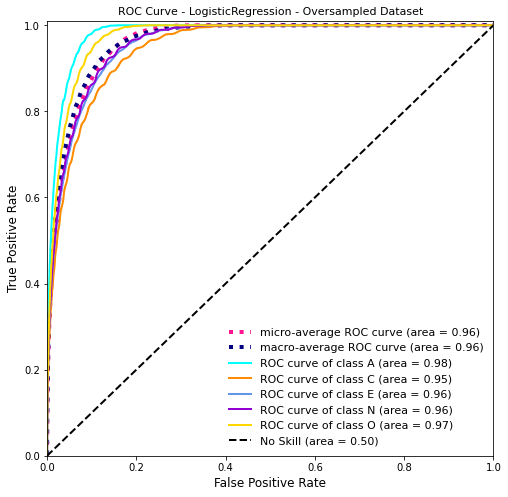

In [46]:
plot_roc_curve_multiclass(models['LogisticRegression'],X_res,y_res, label = '- Oversampled Dataset')